In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
# import decoupler as dc
import plotnine as p9

/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import liana as li

In [3]:
import muon as mu

/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/umap/distances.py:108

In [4]:
## load slide
slide = "B1"
exp = "V11L12-109" # V11T17-102 V11L12-109 V11T16-085
slide_path = f"data/VicariEtAl/sma/{exp}/{exp}_{slide}/output_data"
rna_path = slide_path + f"/{exp}_{slide}_RNA/outs/"

rna = sq.read.visium(rna_path, counts_file="filtered_feature_bc_matrix.h5")

msi = pd.read_csv(slide_path + f"/{exp}_{slide}_MSI/{exp}_{slide}.Visium.FMP.220826_smamsi.csv")


/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
# Only for mouse
lesion = pd.read_csv(rna_path + "/lesion.csv").set_index("Barcode")
region = pd.read_csv(rna_path +  "/region.csv").set_index("Barcode")
rna.obs = rna.obs.join(lesion)
rna.obs = rna.obs.join(region)

In [6]:
rna.obs

,in_tissue,array_row,array_col,lesion,region
AAACAAGTATCTCCCA-1,1,50,102,lesioned,striatum
AAACAGCTTTCAGAAG-1,1,43,9,intact,not_striatum
AAACATTTCCCGGATT-1,1,61,97,lesioned,striatum
AAACCCGAACGAAATC-1,1,45,115,lesioned,not_striatum
AAACCGGAAATGTTAA-1,1,54,124,lesioned,not_striatum
...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,1,24,64,intact,not_striatum
TTGTTCTAGATACGCT-1,1,21,3,intact,not_striatum
TTGTTGTGTGTCAAGA-1,1,31,77,lesioned,not_striatum
TTGTTTCCATACAACT-1,1,45,27,intact,striatum


In [7]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
sc.pp.scale(rna)

In [8]:
sc.pp.pca(rna)
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)

In [9]:
sc.tl.leiden(rna, resolution=0.1)
sc.tl.umap(rna)

... storing 'lesion' as categorical
... storing 'region' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/dbdimitrov/anaconda3/envs/test-env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


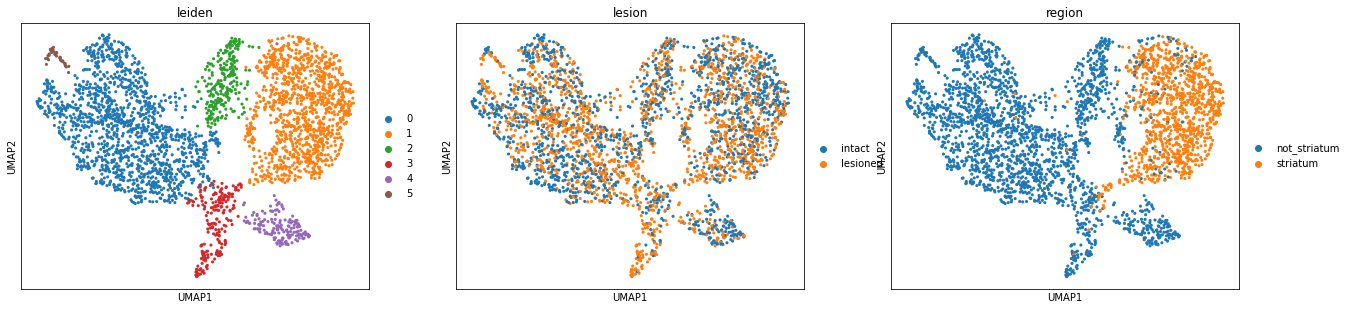

In [10]:
sc.pl.umap(rna, color=["leiden", "lesion", "region"])

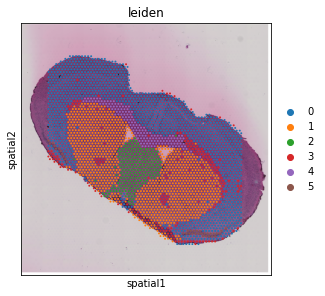

In [11]:
sq.pl.spatial_scatter(rna, color="leiden")

MSI

In [ ]:

# positions = pd.read_csv(rna_path + "/spatial/tissue_positions_list.csv", header=None)
# positions.rename(columns={0:"barcode", 2:"x", 3:"y"}, inplace=True)
# positions = positions[positions['barcode'].isin(rna.obs.index)]

In [ ]:
positions = (rna.obs[['array_row', 'array_col']].
             reset_index(names='barcode').
             rename(columns={'array_row':'x', 'array_col':'y'}))
positions.index.name = None

In [ ]:
msi = (msi.merge(positions, how='right').
             set_index('barcode'))

In [ ]:
msi.isna().sum().sum()

In [ ]:
msi.obs

In [ ]:
# replace NaNs with 0
msi.fillna(0, inplace=True)

In [ ]:
msi = msi.drop(['x', 'y'], axis=1)

In [ ]:
msi = sc.AnnData(X=msi.values,
                 obs=pd.DataFrame(index=msi.index),
                 var=pd.DataFrame(index=msi.columns))

In [ ]:
msi.obs = rna.obs
msi.uns = rna.uns
msi.obsm = rna.obsm

In [ ]:
mdata = mu.MuData({'rna':rna, 'msi':msi})

In [ ]:
sc.pp.normalize_total(mdata.mod['rna'], target_sum=10e5)
sc.pp.log1p(mdata.mod['rna'])

In [ ]:
sc.pp.normalize_total(mdata.mod['msi'], target_sum=10e5)
sc.pp.log1p(mdata.mod['msi'])
sc.pp.scale(mdata.mod['msi'])

In [ ]:
sq.pl.spatial_scatter(msi, color=[# '674.2522', '674.26665', '674.26906',
                                  '674.2805', # Dopamine
                                #   '674.28592', '674.28833'
                                  ])

In [ ]:
#  check for strings that contain 674 (Dopamine)
msk = ['674' in x for x in msi.var.index]
msi.var.index[msk]

In [ ]:
sq.pl.spatial_scatter(rna, color=['lesion', 'region'])